<a href="https://colab.research.google.com/github/xychong/miniproject/blob/main/EE4483_Mini_Project_%5BData_Augmentation_3%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
print(tf.__version__)

2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_path = "/content/drive/MyDrive/Data/train"
train_path_cat = "/content/drive/MyDrive/Data/train/cat"
train_path_dog = "/content/drive/MyDrive/Data/train/dog"

val_path = "/content/drive/MyDrive/Data/val"
val_path_cat = "/content/drive/MyDrive/Data/val/cat"
val_path_dog = "/content/drive/MyDrive/Data/val/dog"

test_path = "/content/drive/MyDrive/Data/test/"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
#train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(150,150),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

val_dataset = val_datagen.flow_from_directory(val_path,
                                              target_size=(150,150),
                                              batch_size = 32,
                                              class_mode = 'binary')

test_dataset = test_datagen.flow_from_directory(test_path,
                                              target_size=(150,150),
                                              batch_size = 32,
                                              class_mode = 'binary')

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [7]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # drop the Dense layers!
                 input_shape=(150, 150, 3))
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
model = keras.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer 
        keras.layers.Flatten(),
        keras.layers.Dropout(0.50),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dropout(0.20),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.10),         
        keras.layers.Dense(1, activation='sigmoid')    
    ])

trainable = False
for layer in vgg_base.layers:
    if layer.name == 'block5_conv2':
        trainable = True
    # will set to trainable = False until we hit the 
    # "block5_conv2" layer    
    layer.trainable = trainable

In [9]:
for layer in vgg_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f71bbd061d0> False
<keras.layers.convolutional.Conv2D object at 0x7f71b9485910> False
<keras.layers.convolutional.Conv2D object at 0x7f71b947f390> False
<keras.layers.pooling.MaxPooling2D object at 0x7f71b947c4d0> False
<keras.layers.convolutional.Conv2D object at 0x7f71b94820d0> False
<keras.layers.convolutional.Conv2D object at 0x7f71b94a8a90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f71b948f350> False
<keras.layers.convolutional.Conv2D object at 0x7f71bab5f490> False
<keras.layers.convolutional.Conv2D object at 0x7f71bab64a90> False
<keras.layers.convolutional.Conv2D object at 0x7f71bac46c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f71bab5f8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f71bab70b90> False
<keras.layers.convolutional.Conv2D object at 0x7f71bab76290> False
<keras.layers.convolutional.Conv2D object at 0x7f71bab705d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f71baaffcd0>

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [11]:
# Adjust the learning rate of Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt ,loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
train_steps = train_dataset.n // 32
val_steps = val_dataset.n // 32
test_steps = test_dataset.n // 32

print(train_steps)
print(val_steps)
print(test_steps)

100
25
0


In [13]:
training = model.fit(train_dataset, steps_per_epoch=train_steps, epochs=10, validation_data=val_dataset, validation_steps=val_steps)

Epoch 1/10
100/100 [==============================] - 975s 10s/step - loss: 0.4760 - accuracy: 0.7600 - val_loss: 0.2612 - val_accuracy: 0.8888
Epoch 2/10
100/100 [==============================] - 970s 10s/step - loss: 0.3016 - accuracy: 0.8691 - val_loss: 0.1905 - val_accuracy: 0.9187
Epoch 3/10
100/100 [==============================] - 972s 10s/step - loss: 0.2703 - accuracy: 0.8866 - val_loss: 0.2316 - val_accuracy: 0.9013
Epoch 4/10
100/100 [==============================] - 971s 10s/step - loss: 0.2434 - accuracy: 0.8969 - val_loss: 0.1711 - val_accuracy: 0.9237
Epoch 5/10
100/100 [==============================] - 970s 10s/step - loss: 0.2255 - accuracy: 0.8991 - val_loss: 0.2187 - val_accuracy: 0.9062
Epoch 6/10
100/100 [==============================] - 970s 10s/step - loss: 0.2077 - accuracy: 0.9106 - val_loss: 0.1695 - val_accuracy: 0.9250
Epoch 7/10
100/100 [==============================] - 971s 10s/step - loss: 0.1983 - accuracy: 0.9141 - val_loss: 0.1657 - val_accuracy:

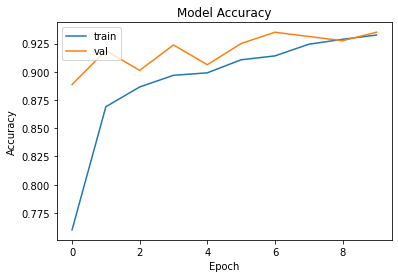

In [14]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

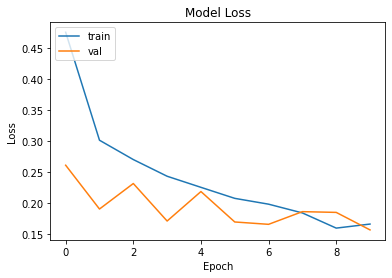

In [15]:
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
submission = pd.DataFrame(columns=['id','label'])
submission

,id,label


In [17]:
test_label = []
count = 0
for filename in os.listdir(test_path):
  first_word = filename.split('.')[0]
  img = image.load_img(test_path + filename, target_size = (150,150)) # load and resize image as 150x150
  Y = image.img_to_array(img) # convert image into a numpy array 
  X = np.expand_dims(Y,axis=0) # expand the dimension of that array
  val = model.predict(X)
  test_label.append(int(val))
  submission = submission.append({'id': int(first_word),'label': int(val)}, ignore_index=True)
  count += 1

print(test_label)

[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

In [18]:
submission
submission.to_csv('/content/drive/MyDrive/Data/submission.csv')  

In [19]:
sorted_submission = submission.sort_values('id')
sorted_submission
sorted_submission.to_csv('/content/drive/MyDrive/Data/sorted_submission.csv')  

In [21]:
sorted_submission

,id,label
466,1,1
431,2,1
459,3,1
345,4,1
376,5,1
...,...,...
315,496,1
337,497,1
164,498,0
151,499,1


In [20]:
#loss, acc = model.evaluate(train_dataset, steps=train_steps, verbose=1)
#print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))

#loss, acc = model.evaluate_generator(val_dataset, steps=val_steps, verbose=1)
#print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))

#loss, acc = model.evaluate_generator(test_dataset, steps=test_steps, verbose=1)
#print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))